In [1]:
import tensorflow as tf
from keras.src.layers import Bidirectional
from tensorflow.keras import mixed_precision
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
mixed_precision.set_global_policy('mixed_float16')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('data/imdb_dataset.csv')


2025-12-13 13:31:28.747161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 13:31:29.188670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 13:31:38.490619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


In [2]:
import numpy as np

#Define GloVe parameters
GLOVE_FILE = 'data/glove.6B.100d.txt'
EMBEDDING_DIM = 100

#Load GloVe vectors into a dictionary
embeddings_index = {}
print(f"Loading GloVe vectors from {GLOVE_FILE}...")

try:
    with open(GLOVE_FILE, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
except FileNotFoundError:
    print(f"\n*** ERROR: GloVe file not found. ***")
    print(f"Please download '{GLOVE_FILE}' and place it in your project folder.")

print(f"Successfully loaded {len(embeddings_index)} word vectors.")

Loading GloVe vectors from data/glove.6B.100d.txt...
Successfully loaded 400000 word vectors.


Split the original DataFrame into train and test sets
80% for training, 20% for testing.

In [3]:
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

print(f"Full dataset size: {len(dataset)}")
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
train_df.head(10)

Full dataset size: 50000
Training set size: 40000
Test set size: 10000


,review,sentiment
39087,That's what I kept asking myself during the ma...,negative
30893,I did not watch the entire movie. I could not ...,negative
45278,A touching love story reminiscent of In the M...,positive
16398,This latter-day Fulci schlocker is a totally a...,negative
13653,"First of all, I firmly believe that Norwegian ...",negative
13748,I don't know how this movie received so many p...,negative
23965,Nightmare Weekend stars a cast of ridiculous a...,negative
45552,":::SPOILER ALERT:::<br /><br />Soooo, Arnie's ...",negative
30219,The people who are bad-mouthing this film are ...,positive
24079,"<br /><br />As usual, I was really looking for...",negative


Defining dataset parameters

In [4]:
VOCAB_SIZE = 8000
MAX_LEN = 250

Tokenization

In [5]:
# Create the 0/1 labels
y_train = train_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
y_test = test_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Process Reviews (X data)
tokenizer = Tokenizer(num_words=VOCAB_SIZE)

#Fit the tokenizer ONLY on the training text
tokenizer.fit_on_texts(train_df['review'])

# transform both train and test text
X_train = tokenizer.texts_to_sequences(train_df['review'])
X_test = tokenizer.texts_to_sequences(test_df['review'])

#Pad the sequences
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

print("\n--- First 10 rows of processed X_train (numbers) ---")
print(X_train[:10])
np.set_printoptions(threshold=np.inf)
print("\n--- Full 1st row of processed X_train ---")
print(X_train[0])
np.set_printoptions(threshold=0)


--- First 10 rows of processed X_train (numbers) ---
[[  13   92  485 ...  205  351 3856]
 [ 438   17   10 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [  47 1025    8 ...  661  335  155]
 [   0    0    0 ...   17   63    6]
 [   5  131   71 ...  483    7    7]]

--- Full 1st row of processed X_train ---
[  13   92  485 6830   15    3  364 1182   61    8    1  470  216 1014
    5 4160    8    3  174    4   34  440  697  623   12 3748  237  111
  848   35  170   30  219  197    1  428  367   55 3765    3  278    7
    7  157 1707  187    6    1  727 1935    1 1200    4 2946 3749 1828
    2  147  144    3  228    4    3  207  323    2  144 1083   16   88
    4  132 2871   18   10  153   99    4    1 4020  302   11   17 1001
   35    1  496  492 2619  249   71   77  107  107  698   60   86 1047
 1363    5  229  132   23 4360   31  138  209 1154   14 4501 5313   31
    3 2386    2    8   11    6    3  445   14  624    4    1  718 2959
    1 1278    2   71 3616    1  166 

In [6]:
# Get your tokenizer's vocabulary
VOCAB_SIZE_FINAL = tokenizer.num_words + 1
embedding_matrix = np.zeros((VOCAB_SIZE_FINAL, EMBEDDING_DIM))
words_found = 0
print(f"Building embedding matrix for top {VOCAB_SIZE} words...")
for word, i in tokenizer.word_index.items():
    if i >= VOCAB_SIZE_FINAL:
        continue

    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_found += 1

print(f"Done. Found {words_found} / {VOCAB_SIZE} words in GloVe.")

Building embedding matrix for top 8000 words...
Done. Found 7858 / 8000 words in GloVe.


Verifying train split 50/50

In [7]:
# dd = pd.Series(y_train).value_counts()
# sns.barplot(x=np.array(['negative','positive']),y=dd.values)
# plt.show()

Verifying test split 50/50

In [8]:
# dd = pd.Series(y_test).value_counts()
# sns.barplot(x=np.array(['negative','positive']),y=dd.values)
# plt.show()

Hyperparameters

In [9]:
EMBEDDING_DIM = 100
LSTM_UNITS = 256  # Tuned: was 100
DROPOUT = 0.45    # Tuned: was 0.12

Building model

In [10]:
from keras.src.callbacks import EarlyStopping
from keras.src import regularizers

model = Sequential()

# turns your number sequences (e.g., [0, 0, 5, 23])
# into meaningful vectors.
model.add(Embedding(
    input_dim=VOCAB_SIZE_FINAL,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=True,
    input_length=MAX_LEN
))

# Tuned: Changed to 1 layer (was 2), return_sequences=False
model.add(Bidirectional(LSTM(
    units=LSTM_UNITS,
    dropout=DROPOUT,
    return_sequences=False,  # Tuned: was True (for 2-layer model)
    # kernel_regularizer=regularizers.L2(0.001)
)))

# Tuned: Removed second LSTM layer
# model.add(LSTM(
#     units=LSTM_UNITS,
#     dropout=DROPOUT,
#     # kernel_regularizer=regularizers.L2(0.001)
# ))

model.add(Dense(units=1, activation='sigmoid'))

early_stopper = EarlyStopping(monitor='val_accuracy',
                            patience=2,
                            restore_best_weights=True)

print(model.summary())

/mnt/c/Users/minda/PycharmProjects/ImdbSentimentAnalysis/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1765625523.083447   68967 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5518 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       800,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,100 (3.05 MB)

 Trainable params: 800,100 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

None


Compiling model

In [11]:
from tensorflow.keras.optimizers import Adam

LEARNING_RATE = 0.001  # Tuned: was 0.00005
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nModel compiled successfully.")


Model compiled successfully.


Training model

In [12]:
import time

BATCH_SIZE = 256  # How many reviews to process at a time
EPOCHS = 50  # How many times to loop over the entire training dataset

print("\nStarting training...")
start_time = time.time()

history = model.fit(
    X_train, y_train,
    verbose=1,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stopper]
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")
print(f"\nTraining complete.")
print("\nTraining complete.")


Starting training...
Epoch 1/50


2025-12-13 13:32:05.121831: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-12-13 13:32:05.875597: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.6456 - loss: 0.6214 - val_accuracy: 0.8044 - val_loss: 0.4527
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7974 - loss: 0.4429 - val_accuracy: 0.8709 - val_loss: 0.3141
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8583 - loss: 0.3317 - val_accuracy: 0.8835 - val_loss: 0.2810
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8780 - loss: 0.2895 - val_accuracy: 0.8947 - val_loss: 0.2598
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8919 - loss: 0.2633 - val_accuracy: 0.8953 - val_loss: 0.2570
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8989 - loss: 0.2470 - val_accuracy: 0.9012 - val_loss: 0.2385
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9066 - loss: 0.2302 - val_accuracy: 0.8984 - val_loss: 0.2619
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9108 - loss: 0.2217 - val_accuracy: 0.90

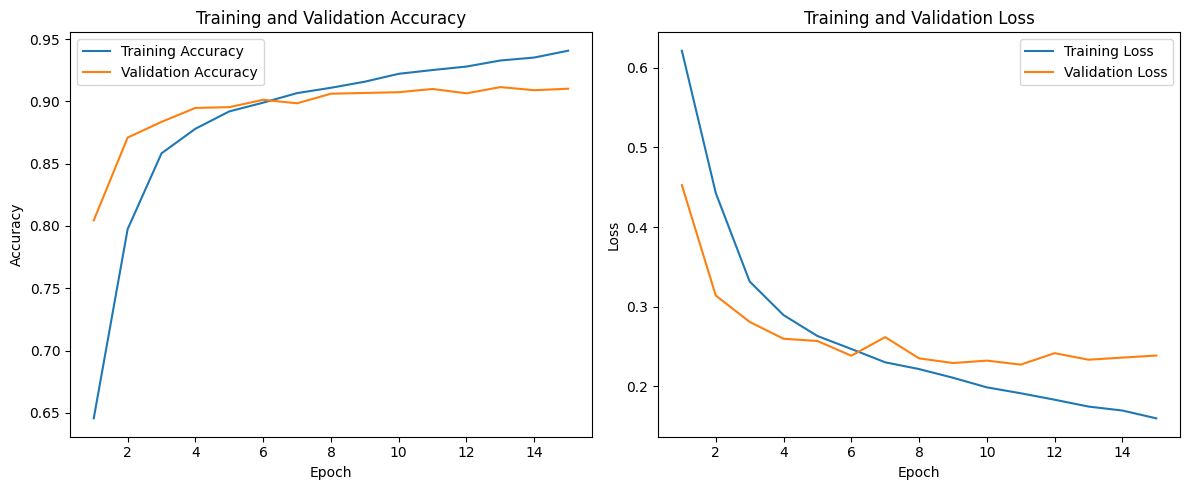

In [13]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Generating predictions on X_test...


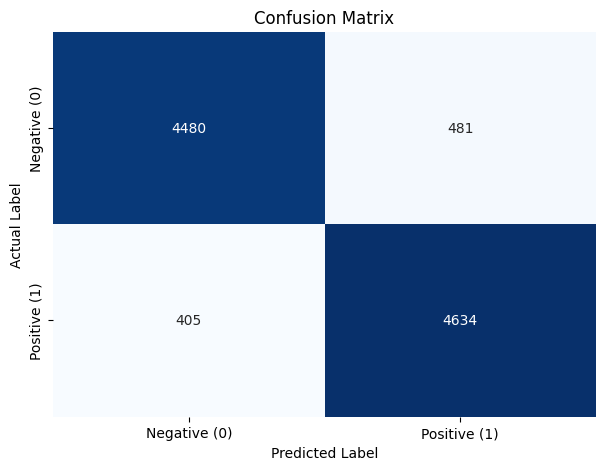

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Get raw probabilities (scores between 0 and 1)
print("Generating predictions on X_test...")
y_pred_probs = model.predict(X_test, verbose=0)

# Apply a threshold (0.5). Scores > 0.5 are 1 (Positive), others are 0 (Negative).
y_pred_binary = (y_pred_probs > 0.5).astype(int)

#Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)

#Plot the Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=['Negative (0)', 'Positive (1)'],
    yticklabels=['Negative (0)', 'Positive (1)']
)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Get final score

In [15]:
print("Evaluating model on test data...")
score, acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f"\nFinal Test Loss: {score:.4f}")
print(f"Final Test Accuracy: {acc:.4f}")

Evaluating model on test data...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9114 - loss: 0.2335

Final Test Loss: 0.2335
Final Test Accuracy: 0.9114


Validating

In [16]:
texts_to_predict = [
    "This was the best movie I have ever seen!",
    "I really hated this film. It was slow and boring.",
    "The acting was decent, but the plot was a little weak.",
    "Scariest movie I have ever seen and",
]


def get_sentiment_prediction(text):
    sequence = tokenizer.texts_to_sequences([text])

    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN)

    prediction = model.predict(padded_sequence, verbose=0)

    score = prediction[0][0]
    label = "Positive" if score > 0.5 else "Negative"

    return score, label


import textwrap
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

text_width = 40

print("Predicting...\n")
print("=" * (text_width + 4))

for text in texts_to_predict:
    score, sentiment = get_sentiment_prediction(text)

    wrapped_text = textwrap.fill(text, width=text_width)

    print(wrapped_text)

    print(f"\n  -> Prediction: {score:.4f} ({sentiment})")
    print("=" * (text_width + 4))

Predicting...

This was the best movie I have ever
seen!

  -> Prediction: 0.9561 (Positive)
I really hated this film. It was slow
and boring.

  -> Prediction: 0.0113 (Negative)
The acting was decent, but the plot was
a little weak.

  -> Prediction: 0.0122 (Negative)
Scariest movie I have ever seen and

  -> Prediction: 0.5996 (Positive)
